# Molecular dynamics simulations with the Lennard-Jones potential

## Setup

The first thing you will need to do is install the [ASE package](https://wiki.fysik.dtu.dk/ase/) (for Atomic Simulation Environment).  First, make sure you are in the correct Python virtual environment.  If you have been installing packages with `pip`, you can just run:

    pip install ase

and it should install it into the correct environment.  Make sure it works by running the cell below:

In [2]:
import ase

In [36]:
!pip install ase

If you get errors at this stage, please ask for help.

**Note for Anaconda/conda users**: The ASE package is not available through Anaconda's default distribution channels.  It is, however, available from [conda-forge](https://conda-forge.org/packages/).  You can use the following installation command (again, make sure you are in the correct environment):

    conda install -c conda-forge --strict-channel-priority ase

and try the `import` command above.

### Other imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Viewing atomic structures

It is important that we visualize atomic structures and their evolution in time, so that we can _see_ the (qualitative) behaviour of a system.  ASE provides a few ways to do this.  The most full-featured and user-friendly one is the [ASE GUI](https://wiki.fysik.dtu.dk/ase/ase/gui/gui.html), accessible from the command line with:

    ase gui <structure_file.xyz>

where `<structure_file.xyz>` is a file containing the structures you want to view.

You can also view structures directly in the notebook environment.  This can be very useful for quick checking of structures without interrupting your workflow.  To do this, you first have to import ASE's `view()` function:

In [28]:
from ase.visualize import view

Now, if you just call `view(structure)` on an atomic structure, you will see a visualization directly in the notebook.  Note that this visualization is still a bit basic; you can get more features by installing the `nglview` plugin:

    pip install nglview
or

    conda install -c conda-forge --strict-channel-priority nglview

You can now call the viewer function like: `view(structure, viewer='ngl')` and you will get a more interactive structure viewer.  Try it out below!

## Initial configuration

Let's start with an _initial configuration_ of atoms.  I've prepared a starting structure (a crystal of 32 Ar atoms in the FCC close-packed configuration) using the code below, but you can just load the structure from the file included with this tutorial.

In [ ]:
from ase.build import bulk, make_supercell
starting_unit = bulk('Ar', 'fcc', a=5.0, cubic=True)
starting_config = make_supercell(starting_unit, 2*np.eye(3, dtype=int))

In [3]:
import ase.io

In [28]:
ase.io.write('starting_config.xyz', starting_config)

----

In [52]:
starting_config = ase.io.read('starting_config.xyz')

In [29]:
# Note: This may not work if you haven't gotten nglview installed or configured correctly
view(starting_config, viewer='x3d')

## Defining the potential

Now, we will define the _potential energy surface_ that determines how the atoms interact.  In some ways, this is the most important ingredient in an atomistic simulation!

As discussed, we will use the Lennard-Jones potential here, defined by the equation:
$$
u(r) = 4\varepsilon \left(\left(\frac{r_0}{r}\right)^{12} - \left(\frac{r_0}{r}^{6}\right)\right)
$$
applied between all pairs of atoms within some _maximum distance_ of each other.  This maximum distance is another important parameter of the potential, and it is typically called the "cutoff".

To calculate this potential for any atomic configuration, we will use ASE's built-in potential _calculator_:

In [19]:
from ase.calculators.lj import LennardJones

In [ ]:
?LennardJones

Init signature: LennardJones(**kwargs)
Docstring:     
Lennard Jones potential calculator

see https://en.wikipedia.org/wiki/Lennard-Jones_potential

The fundamental definition of this potential is a pairwise energy:

``u_ij = 4 epsilon ( sigma^12/r_ij^12 - sigma^6/r_ij^6 )``

For convenience, we'll use d_ij to refer to "distance vector" and
``r_ij`` to refer to "scalar distance". So, with position vectors `r_i`:

``r_ij = | r_j - r_i | = | d_ij |``

Therefore:

``d r_ij / d d_ij = + d_ij / r_ij``
``d r_ij / d d_i  = - d_ij / r_ij``

The derivative of u_ij is:

::

    d u_ij / d r_ij
    = (-24 epsilon / r_ij) ( 2 sigma^12/r_ij^12 - sigma^6/r_ij^6 )

We can define a "pairwise force"

``f_ij = d u_ij / d d_ij = d u_ij / d r_ij * d_ij / r_ij``

The terms in front of d_ij are combined into a "general derivative".

``du_ij = (d u_ij / d d_ij) / r_ij``

We do this for convenience: `du_ij` is purely scalar The pairwise force is:

``f_ij = du_ij * d_ij``

The total force on an atom is:

``f_

Take a moment to check out the documentation.  This is also available online in the [ASE documentation page](https://wiki.fysik.dtu.dk/ase/ase/calculators/others.html#lennard-jones).

We will need to initialize it with a few parameters -- besides the cutoff radius, we need values for $\varepsilon$ and $r_0$.  Let's use the values proposed in this publication: [J. A. White, _J. Chem. Phys._ **111**, 9352-9355 (1999)]().

The proposed values are: $r_0 = 3.345\,\text{Å}$ and $\varepsilon = 125.7 k_B$, where $k_B$ is Boltzmann's constant.

But hang on -- we need to make sure to convert these to the units that ASE uses!  Luckily, ASE already uses Ångström for length units.  For the energy units, we just use the `ase.units` module to find the appropriate conversion:

In [ ]:
ase.units.kB

8.617330337217213e-05

So, putting it together, we initialize the potential as follows:

In [53]:
lj_argon_calc = LennardJones(sigma=3.345, epsilon=125.7*ase.units.kB, rc=10.0, smooth=True)

(I've somewhat arbitrarily chosen a cutoff radius of 10 Å here because that's the length of our cell.  You can play around with different cutoff values later, although be warned that the effect on the results can be quite subtle.)

## Doing something with the potential

Now that we've defined the potential, let's do something useful with it!  The simplest thing would be an energy minimization, where we try to find the structure that minimizes the energy of this potential energy surface.  Note that this structure will generally depend on the potential and its parameters!

In [54]:
starting_config.set_calculator(lj_argon_calc)

<ipython-input-54-5ba69273cfc4>:1: FutureWarning: Please use atoms.calc = calc
  starting_config.set_calculator(lj_argon_calc)


In [55]:
from ase.optimize import BFGS

In [56]:
from ase.filters import ExpCellFilter

In [57]:
# Slightly annoying extra step we need in order to optimize the cell (volume) in addition to the positions
atoms_cell = ExpCellFilter(starting_config, hydrostatic_strain=True)
opt = BFGS(atoms_cell)
opt.run(fmax=0.005)

      Step     Time          Energy          fmax
BFGS:    0 16:53:16       -2.778298        0.000596


<ipython-input-57-775d2bb4c5ca>:2: DeprecationWarning: Use FrechetCellFilter for better convergence w.r.t. cell variables.
  atoms_cell = ExpCellFilter(starting_config, hydrostatic_strain=True)


np.True_

In [58]:
starting_config

Atoms(symbols='Ar32', pbc=True, cell=[[10.347299727835516, -2.113899567688366e-18, 5.580984014422782e-20], [-6.08488378391463e-18, 10.347299727835516, -1.787135559351749e-20], [-2.43572762310049e-18, -9.07649068997225e-20, 10.347299727835516]], calculator=LennardJones(...))

In [42]:
starting_config.cell[0,0] / 2

np.float64(5.173649863917758)

### Question

What is the _cell parameter_ of the resulting, optimized structure?  How does it compare to the experimental value (for solid argon)?

## Run dynamics

Okay, now we get to the fun part!  Let's run some actual simulations and see the atoms move!

In [10]:
import ase.md

First, we need an "integrator" that actually solves the equations of motion.  Velocity Verlet is a good choice:

In [12]:
from ase.md import MDLogger

In [11]:

vv = ase.md.VelocityVerlet(atoms=starting_config, timestep=1.0, trajectory='trial_traj.xyz')
vv.attach(MDLogger(vv, starting_config, 'md.log', header=True, stress=False,
          peratom=False, mode="a"), interval=1)

And now we just run it for 50 timesteps and see what happens!

In [45]:
vv.run(50)

True

Finally, try loading the output in the `ase gui` and see if we got anything...

In [46]:
traj = ase.io.read('trial_traj.xyz', '-50:')

In [49]:
view(traj[10], viewer='x3d')

----
SPOILER ALERT



...nothing happened.  That's because we haven't initialized the _velocities_ on the atoms, so they're not moving!  Let's set them up with a nice initial, "thermal" velocity.

In [9]:
from ase.md import velocitydistribution

In [13]:
velocitydistribution.MaxwellBoltzmannDistribution(starting_config, temperature_K=40)

In [55]:
vv.run(50)

True

In [57]:
import numpy as np

In [58]:
md_log = np.loadtxt('md.log', skiprows=52)

In [59]:
md_log

array([[ 0.0000e+00, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 1.0200e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 2.0400e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 3.0500e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 4.0700e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 5.0900e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 6.1100e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 7.1300e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 8.1400e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 9.1600e-02, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 1.0180e-01, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 1.1200e-01, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 1.2220e-01, -2.7783e+00, -2.7783e+00,  0.0000e+00,  0.0000e+00],
       [ 1.3230e-01, -2.7783e+00, -2.7

In [60]:
time, e_tot, e_pot, e_kin, T = md_log.T

In [62]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Energy / eV')

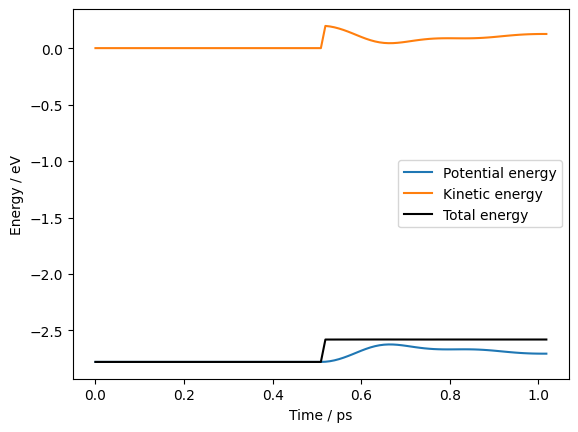

In [68]:
plt.plot(time, e_pot, c='C0', label='Potential energy')
plt.plot(time, e_kin, c='C1', label='Kinetic energy')
plt.plot(time, e_tot, c='k', label='Total energy')
plt.legend()
plt.xlabel('Time / ps')
plt.ylabel('Energy / eV')

Text(0, 0.5, 'Temperature / K')

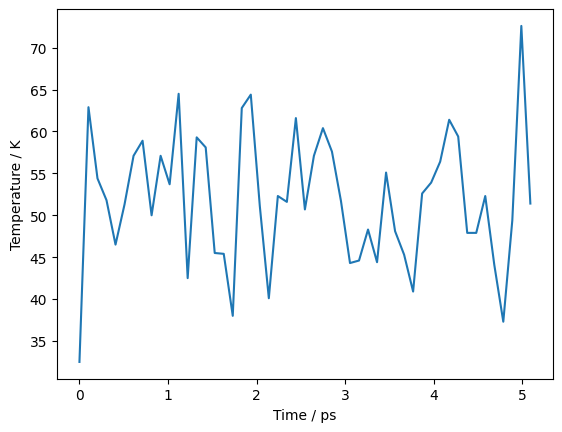

In [78]:
plt.plot(time, T)
plt.xlabel('Time / ps')
plt.ylabel('Temperature / K')

## Constant-temperature dynamics with the NVT ensemble

In [88]:
nvt = ase.md.Langevin(atoms=starting_config, timestep=1.0, trajectory='traj_nvt.xyz',
                      temperature_K=200, friction=0.1 / ase.units.fs)

In [89]:
nvt.attach(MDLogger(nvt, starting_config, 'md_nvt.log', header=True, stress=True,
           peratom=False, mode="w"), interval=10)

In [90]:
nvt.run(500)

True

In [69]:
starting_config

Atoms(symbols='Ar32', pbc=True, cell=[[10.347299727835516, -2.113899567688366e-18, 5.580984014422782e-20], [-6.08488378391463e-18, 10.347299727835516, -1.787135559351749e-20], [-2.43572762310049e-18, -9.07649068997225e-20, 10.347299727835516]], momenta=..., calculator=LennardJones(...))

In [84]:
md_log_nvt = np.loadtxt('md_nvt.log', skiprows=1)

In [85]:
time, e_tot, e_pot, e_kin, T = md_log_nvt.T

Text(0, 0.5, 'Energy / eV')

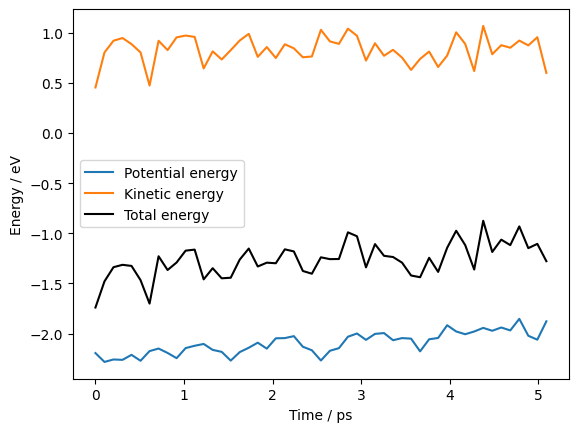

In [86]:
plt.plot(time, e_pot, c='C0', label='Potential energy')
plt.plot(time, e_kin, c='C1', label='Kinetic energy')
plt.plot(time, e_tot, c='k', label='Total energy')
plt.legend()
plt.xlabel('Time / ps')
plt.ylabel('Energy / eV')

Text(0, 0.5, 'Temperature / K')

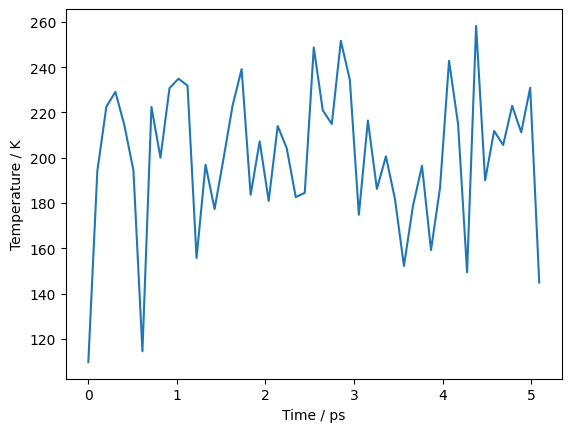

In [87]:
plt.plot(time, T)
plt.xlabel('Time / ps')
plt.ylabel('Temperature / K')

## Constant pressure and temperature (NPT)

In [91]:
from ase.md.nptberendsen import NPTBerendsen

In [112]:
npt = NPTBerendsen(atoms=starting_config, timestep=1.0, trajectory='traj_npt.xyz',
                   pressure_au=100000*ase.units.bar, temperature_K=200,
                   taut=100*ase.units.fs, taup=500*ase.units.fs, compressibility=1)

In [113]:
ase.units.bar

6.241509125883258e-07

In [114]:
npt.attach(MDLogger(npt, starting_config, 'md_npt.log', header=True, stress=True,
           peratom=False, mode="w"), interval=10)

In [115]:
npt.run(500)

ValueError: Encountering floating point overflow. The value of p too large for this dataset; For such large p, consider using the special case p=np.inf . 